# Depth Estimation from a single RGB image

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random
from itertools import product
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision
from torchvision import transforms

from network import Whole_Net
from loss import Ranking_Loss
from dataload import Image_Transform, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
batch_size = 16

cuda


In [3]:
dataset = Dataset(transform=Image_Transform())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Training

In [4]:
net = Whole_Net()
# net.load_state_dict(torch.load('depth_generator.pth'))

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(net.parameters(), lr=0.003, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

rank = Ranking_Loss(1000, batch_size)
# criterion = nn.MSELoss()
epochs = 20

In [5]:
net.to(device)
net.train()
losses = []

for epoch in range(epochs):

    running_loss = 0.0
    counter = 1.0

    for img, rd in dataloader:

        img = img.to(device)
        rd = rd.to(device)
        rd_pred = net.forward(img)

        if counter == 1.0:
            print("input:", img.shape)
            print("output:", rd_pred.shape)

        #choose the loss (pre or main)
        loss = rank.calculate_main(rd, rd_pred)
        # loss = criterion(rd, rd_pred)

        print("loss:", loss.item())
        if loss.item() > 0:
            losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        counter += 1.0

    losses.append(running_loss / counter)
    print("Epoch:", epoch, "  ", "Loss:", running_loss / counter)

2421526908875
loss: 0.6000373363494873
loss: 0.6024302244186401
loss: 0.650657594203949
loss: nan
loss: 0.584678590297699
loss: 0.6375914812088013
loss: 0.5565747618675232
loss: 0.7383586168289185
loss: 0.6436688899993896
loss: 0.6360647678375244
loss: 0.6458833813667297
loss: 0.6701772212982178
loss: nan
loss: 0.638806939125061
loss: nan
loss: 0.6539654731750488
loss: 0.6331966519355774
loss: 0.649080753326416
loss: 0.668903648853302
loss: nan
loss: 0.6396740674972534
loss: 0.6556187868118286
loss: 0.6542692184448242
loss: 0.6418548226356506
loss: 0.6399650573730469
loss: 0.6549379825592041
loss: nan
loss: 0.6197652220726013
loss: 0.6396651268005371
loss: nan
loss: 0.6714096665382385
loss: nan
loss: 0.6513680219650269
loss: 0.6440521478652954
loss: 0.6084102392196655
loss: 0.658430278301239
loss: 0.6014799475669861
loss: 0.6528659462928772
loss: 0.5912194848060608
loss: 0.6458990573883057
loss: 0.5923593640327454
loss: 0.6434220671653748
loss: 0.6151567697525024
loss: nan
loss: 0.6156

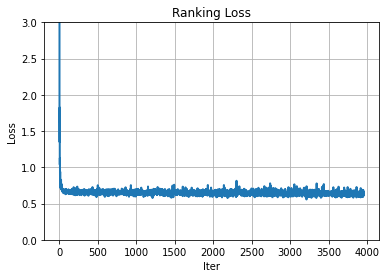

In [6]:
torch.save(net.state_dict(), 'depth_generator_final.pth')
# torch.save(net.state_dict(), 'depth_generator.pth')

plt.title("Ranking Loss")
plt.plot(losses, linewidth=2)
plt.grid()
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.ylim(0.0, 26.0)
plt.show()

# Model's output on training data

In [7]:
model = Whole_Net()
model.load_state_dict(torch.load('depth_generator_final.pth'))
model.to(device)

Whole_Net(
  (convlayer_first): Conv_Block_first(
    (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (convlayer): Conv_Block(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (upsample0): Upsampling(
    (residual_conv): Residual_Conv(
      (relu): ReLU()
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (upsample): Upsample(size=(24, 24), mode=bilinear)
  )
  (upsample1): Upsampling(
    (residual_conv): Residual_Conv(
      (relu): ReLU()
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (upsample): Upsample(size=(48, 48), mode=bilinear)
  )
  (upsample2): Upsampling(
    (residual_conv): Residual_Conv

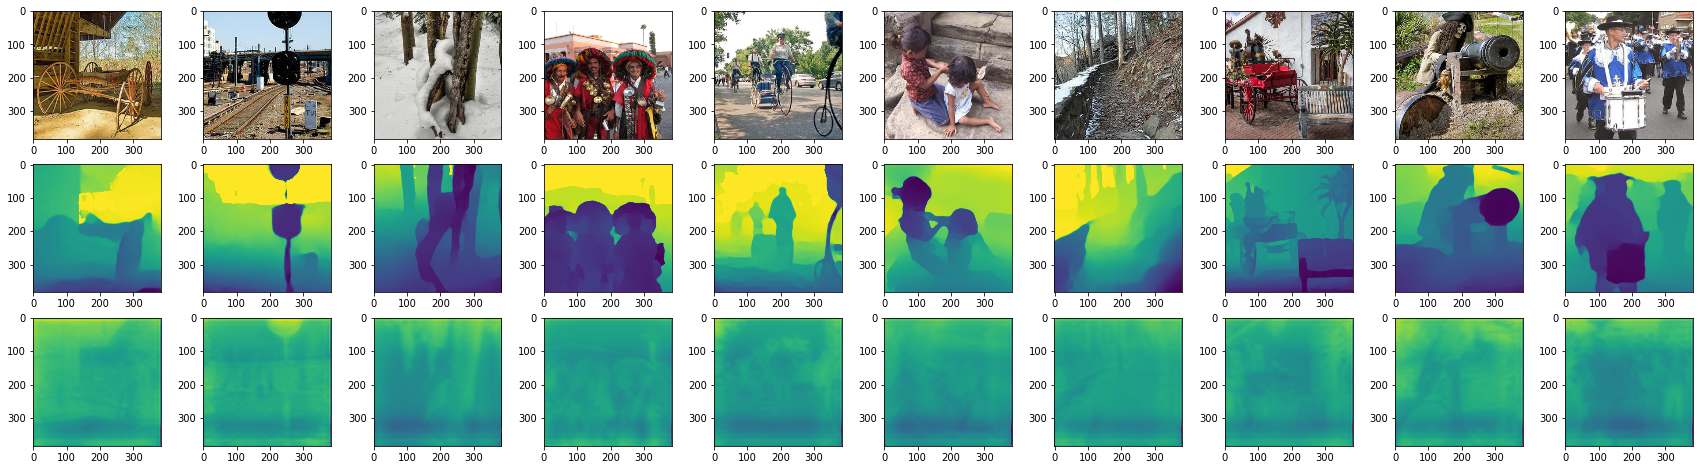

In [10]:
dataset = Dataset(transform=Image_Transform(train=False))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
model.eval()
samples = 10
fig, axs = plt.subplots(3, samples, figsize = (3*samples,8))

i = 0
for img, rd in dataloader:
    img = img.to(device)
    rd = rd.to(device)
    img_pred = model.forward(img)

    img = img.squeeze(0).cpu()
    rd = rd.squeeze(0).cpu()
    img_pred = img_pred.squeeze(0).cpu()
    # print(img.shape)
    axs[0][i].imshow(transforms.ToPILImage()(img), interpolation="nearest")
    axs[1][i].imshow(transforms.ToPILImage()(rd), interpolation="nearest")
    axs[2][i].imshow(transforms.ToPILImage()(img_pred), interpolation="nearest")
    i += 1
    if i==samples: break

# Output on test data

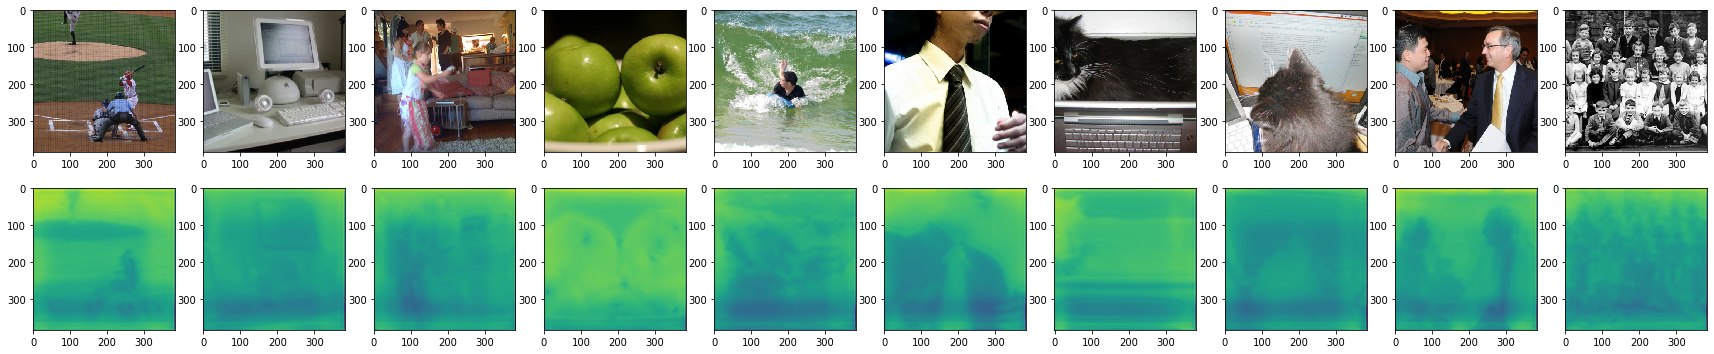

In [24]:
dataset_test = Dataset(transform=Image_Transform(train=False), test=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=True)
model.eval()
samples = 10
fig, axs = plt.subplots(2, samples, figsize = (3*samples,6))

i = 0
for img, rd in dataloader_test:
    img = img.to(device)
    rd = rd.to(device)
    img_pred = model.forward(img)

    img = img.squeeze(0).cpu()
    rd = rd.squeeze(0).cpu()
    img_pred = img_pred.squeeze(0).cpu()
    # print(img.shape)
    axs[0][i].imshow(transforms.ToPILImage()(img), interpolation="nearest")
    axs[1][i].imshow(transforms.ToPILImage()(img_pred), interpolation="nearest")
    i += 1
    if i==samples: break